# **Modul 4 Data Mining 2020 "Support Vector Machines"**

Di modul ini, Anda akan menggunakan SVM (Support Vector Machines) untuk membangun dan melatih model menggunakan catatan sel manusia dan mengklasifikasikan sel , apakah sampel jinak atau ganas.

SVM bekerja dengan memetakan data ke ruang fitur dimensi tinggi sehingga titik data dapat dikategorikan, bahkan ketika data tidak dapat dipisahkan secara linear. Pemisah antara kategori ditemukan, maka data ditransformasikan sedemikian rupa sehingga pemisah dapat digambarkan sebagai hyperplane. Setelah ini, karakteristik data baru dapat digunakan untuk memprediksi grup tempat catatan baru seharusnya berada.

In [0]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

## **Load the Cancer data**

Contoh ini didasarkan pada dataset yang tersedia untuk umum dari Repositori Pembelajaran Mesin UCI [Asuncion dan Newman, 2007](http://mlearn.ics.uci.uci.edu/MLRepository.html). Dataset terdiri dari beberapa ratus catatan sampel sel manusia, yang masing-masing berisi nilai-nilai dari seperangkat karakteristik sel. Bidang dalam setiap catatan adalah:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

In [0]:
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

--2020-02-11 11:02:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0.02s   

2020-02-11 11:02:23 (930 KB/s) - ‘cell_samples.csv’ saved [20675/20675]



## **Load Data From CSV File**

In [0]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head(10)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


Kolom ID berisi pengidentifikasi pasien. Karakteristik sampel sel dari setiap pasien terkandung dalam bidang Clump to MIT. Nilai-nilai tersebut dinilai dari 1 hingga 10, dengan 1 yang paling dekat dengan jinak.

Bidang Kelas berisi diagnosis, yang dikonfirmasi oleh prosedur medis terpisah, apakah sampelnya jinak (nilai = 2) atau ganas (nilai = 4).

Mari kita lihat distribusi kelas berdasarkan ketebalan Rumpun dan Keseragaman ukuran sel:

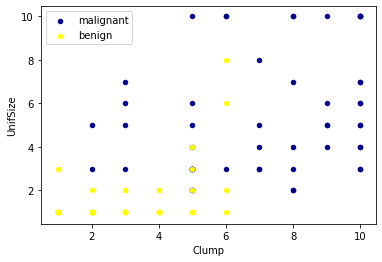

In [0]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## **Data pre-processing and selection**

Mari kita lihat dulu tipe data kolom:

In [0]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Sepertinya kolom BareNuc menyertakan beberapa nilai yang tidak numerik. Kita dapat menghapus baris-baris itu:

In [0]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

## **Feature selection**

Mari kita tentukan set fitur, X:

In [0]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

Definisikan label kelas dari data kita.

In [0]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

Kami ingin model untuk memprediksi nilai Kelas (yaitu, jinak (= 2) atau ganas (= 4)). Karena bidang ini dapat memiliki satu dari hanya dua nilai yang mungkin, kita perlu mengubah level pengukurannya untuk mencerminkan hal ini.

In [0]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## **Train/Test dataset**

Oke, sekarang kita akan membagi dataset menjadi train dan test set:

In [0]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


## **Modeling (SVM with Scikit-learn)**

Algoritma SVM menawarkan pilihan fungsi kernel untuk melakukan pemrosesan. Pada dasarnya, pemetaan data ke ruang dimensi yang lebih tinggi disebut kernelling. Fungsi matematika yang digunakan untuk transformasi dikenal sebagai fungsi kernel dan dapat dari berbagai jenis, seperti:

     1.Linear
     2.Polinomial
     3.Fungsi dasar radial (RBF)
     4.Sigmoid

Masing-masing fungsi memiliki karakteristik, pro dan kontra, dan persamaannya, tetapi karena tidak ada cara mudah untuk mengetahui fungsi mana yang paling baik bekerja dengan dataset yang diberikan, kami biasanya memilih fungsi yang berbeda secara bergantian dan membandingkan hasilnya. Mari kita gunakan default, RBF (Radial Basis Function) untuk lab ini.

In [0]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', gamma='auto')
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Setelah dipasang, model kemudian dapat digunakan untuk memprediksi nilai baru:

In [0]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

## **Evaluation**

Anda juga dapat dengan mudah menggunakan __f1_score__ dari library sklearn:

In [0]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

Mari kita coba Jaccard index untuk akurasi:

In [0]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9635036496350365